# Indego Bikes: Do electric bikes tempt riders to go faster?

<center><b>Abstract</b></center>

Bike shares programs are increasingly popular in cities around the world. Following the success of programs in Amsterdam, Paris, and Copenhagen, the City of Philadelphia launched Indego Bikes in 2015. Indego currently maintains a fleet of over 2,000 bicycles, more than half of which are electric bicycles. Urban cycling can be dangerous. To investigate whether riders travel faster on electric bicycles, we compared the duration of trips made using standard and electric bicycles between a pair of stations two miles apart in downtown Philadelphia. Based on a sample size of 142 trips made in the third quarter of 2023 (94 electric, 48 standard), we found that trips on electric bicycles averaged 0.64 minutes shorter (12.34 versus 12.98 minutes) than on standard bicycles. While the difference in trip duration is statistically significant at a 90% confidence level (p = 0.82), it is too small to conclude that riders of electric bicycles are at greater risk.
    


![Indego riders](Indego_riders.jpg)
You are probably all familiar with [Indego Bikes](https://www.rideindego.com/), the Philly bike-share program. What you may not know is that Indego makes ridership data available on their [trip data](https://www.rideindego.com/about/data/) website. 

In this sample project, we will:
* Explore trip data for the third quarter of 2023
* Make data visualizations
* Formulate an hypothesis
* Test the hypothesis using simulation

In [1]:
import numpy as np
from datascience import *
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

## Load the data

In [2]:
# Note: this is a large data, hence the low_memory flag.
indego = Table.read_table('indego-trips-2023-q3-2.csv', low_memory=False)

## Exploratory Data Analysis

In [3]:
indego.show(3)

trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type
677293140,2,7/1/2023 0:00,7/1/2023 0:02,3271,39.9476,-75.2295,3246,39.9478,-75.223,25775,30,One Way,Indego30,electric
677304406,27,7/1/2023 0:00,7/1/2023 0:27,3060,39.9592,-75.1704,3255,39.951,-75.1644,14583,30,One Way,Indego30,standard
677304584,32,7/1/2023 0:00,7/1/2023 0:32,3057,39.9644,-75.1799,3165,39.9582,-75.1782,5191,1,One Way,Day Pass,standard


In [4]:
indego.num_rows

353256

**That is a lot of bike trips!**

### Trip Duration
The data set includes the trip durations, which is measured in minutes according to the [website](https://www.rideindego.com/about/data/). Let's see how this variable is distributed. 

In [5]:
min_duration = min(indego.column('duration'))
max_duration = max(indego.column('duration'))
print(f" The longest trip was {max_duration} minutes.")
print(f" The shortest trip was {min_duration} minutes.")

 The longest trip was 1440 minutes.
 The shortest trip was 1 minutes.


The Indego site says trips below 1 minute are removed. Probably, the rider changed their mind and put the bike back. **But honestly, can you go anywhere in one minute?  Let's see.**

There is a field "trip_route_category" that is either "Round Trip" or "One Way." If a 1-minute trip is round trip, clearly the bike never left the station. Are their any one way trips?

In [6]:
quick_trips = indego.where('duration', 1).where('trip_route_category', 'One Way')
quick_trips.show(5)

trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type
677454652,1,7/1/2023 7:54,7/1/2023 7:55,3061,39.9543,-75.1776,3161,39.9549,-75.1809,14717,30,One Way,Indego30,standard
677507754,1,7/1/2023 9:48,7/1/2023 9:49,3124,39.9537,-75.1396,3169,39.9538,-75.1426,14598,30,One Way,Indego30,standard
677597704,1,7/1/2023 12:48,7/1/2023 12:49,3190,39.9489,-75.1699,3000,nan,nan,26260,365,One Way,Indego365,electric
677630041,1,7/1/2023 13:53,7/1/2023 13:54,3208,39.9505,-75.1932,3020,39.9486,-75.1901,22610,30,One Way,Indego30,electric
677719554,1,7/1/2023 14:29,7/1/2023 14:30,3330,39.9538,-75.1647,3000,nan,nan,22127,1,One Way,Day Pass,electric


**Wow!** Yes, there are some really fast trips! How is that possible? Let's looks at the start and end stations for the first of these trips in the table above:

start_station is 3061

end_station is 3161

We need to know the station names. Fortunately, Indego provides this in a separate CSV file.

### Load Station Name Data

In [7]:
station_names = Table.read_table('indego-stations-2023-10-01.csv', low_memory=False)
station_names.show(3)

Station_ID,Station_Name,Day of Go_live_date,Status,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
3000,Virtual Station,4/23/2015,Active,nan,nan,nan,nan,nan,nan
3004,Municipal Services Building Plaza,4/23/2015,Inactive,nan,nan,nan,nan,nan,nan
3005,"Welcome Park, NPS",4/23/2015,Active,nan,nan,nan,nan,nan,nan


In [8]:
# We just need the first two columns
station_names = station_names.select('Station_ID', 'Station_Name')
print('Start Station')
print(station_names.where('Station_ID', 3061))
print()
print('End Station')
print(station_names.where('Station_ID', 3161))

Start Station
Station_ID | Station_Name
3061       | 23rd & Market

End Station
Station_ID | Station_Name
3161       | 30th Street Station East


![Quick bike trip](quick_trip.jpg)

If you put these addresses into Google Maps, it says this is a two-minute ride. I can imagine a Penn or Drexel student getting off the train at 30th street station and making this ride in double-quick time, as it is only a third of a mile. Alternatively, the clocks at the two stations might not be perfectly in sync. Or it could be a rounding down a minute and 29 seconds. Anyway, it appears feasible.

Now let's look at the overall distribution of ride durations.

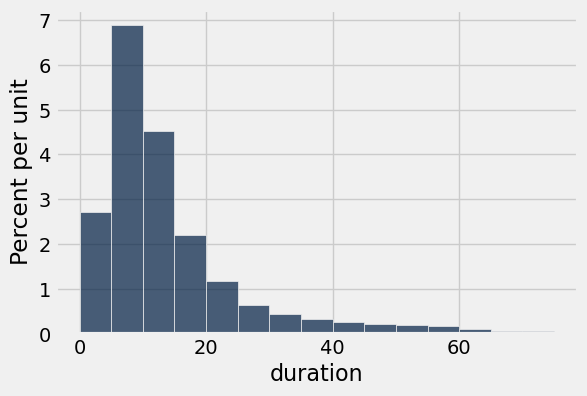

In [9]:
indego.hist('duration', bins=np.arange(0, 80, 5))

We see most trips are short, the peak being 5-10 minutes. Very few are over an hour.

### Trips by Time of Day

Let's look at what the distribution of rides by time of day. This requires parsing the hour from strings such as the following.

In [10]:
st = indego.column("start_time")
example = st[100]
example

'7/1/2023 1:29'

To extract the hour, we can split first split the date and time on the space.

In [11]:
example.split()

['7/1/2023', '1:29']

Then we keep the second term and split on the colon.
example.split()[1].split(:)

In [12]:
example.split()[1].split(":")

['1', '29']

Hour is the first element after this second split. Finally, we convert the hour from a string to an integer so we can plot the distribution.

In [13]:
hour = example.split()[1].split(":")[0]
hour = int(hour)
hour

1

Put this in a function.

In [14]:
def extract_hour(date_time_string):
    '''
    This function expects a datetime string in the form
    '7/1/2023 1:29' and returns just the hour.
    '''
    hour = date_time_string.split()[1].split(":")[0]
    return int(hour)

In [15]:
# Test our function
test_datetime = st[5000]
print(test_datetime)
print(extract_hour(test_datetime))

7/2/2023 16:57
16


Now use our function to add a "start_hour" column to our data table.

In [16]:
indego = indego.with_column('start_hour', indego.apply(extract_hour, 'start_time'))
indego.show(3)

trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type,start_hour
677293140,2,7/1/2023 0:00,7/1/2023 0:02,3271,39.9476,-75.2295,3246,39.9478,-75.223,25775,30,One Way,Indego30,electric,0
677304406,27,7/1/2023 0:00,7/1/2023 0:27,3060,39.9592,-75.1704,3255,39.951,-75.1644,14583,30,One Way,Indego30,standard,0
677304584,32,7/1/2023 0:00,7/1/2023 0:32,3057,39.9644,-75.1799,3165,39.9582,-75.1782,5191,1,One Way,Day Pass,standard,0


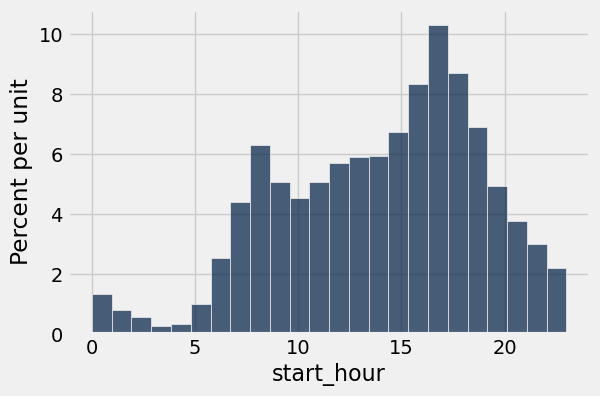

In [17]:
# Use 24 bins for the 24 hours in a day.
indego.hist('start_hour', bins=24)

So the least likely time to start an Indego ride is 3 AM (Hmmm, I wonder why :-), and peak ridership is in the late afternoon and evening with the maximum to about 6 PM (18:00 hours).

### Ride by type of bicycle.
Indego offers two types of bikes: standard and electric. Let's see which constitutes the majority of the rides.

In [18]:
indego_grp = indego.group('bike_type')
indego_grp

bike_type,count
electric,191142
standard,162114


Wow! The ebikes, which Indego introduced only a few year ago, now account for slightly more than half of the rides.

This begs the question: are more riders choosing ebikes because they perfer them, or is it a simple matter of availabilty? To answer this, we need to know what fraction of the bike fleet is ebikes. We can get this using the bike ID in concert with the bike type.

In [19]:
ebike = indego.where('bike_type', 'electric')
ebike_id = np.unique(ebike.column('bike_id'))
num_ebikes = len(ebike_id)

standard = indego.where('bike_type', 'standard')
standard_id = np.unique(standard.column('bike_id'))
num_standard = len(standard_id)

print("The number of ebikes is:", num_ebikes)
print("The number of standard bikes is:", num_standard)

The number of ebikes is: 1230
The number of standard bikes is: 918


So there are more ebikes in the fleet. Compare ratios.

In [20]:
rides_per_ebike = indego_grp.column('count').item(0) / num_ebikes
rides_per_ebike

155.4

In [21]:
rides_per_standard = indego_grp.column('count').item(1) / num_standard
rides_per_standard

176.59477124183007

So even though there are more ebikes, riders show a slight preference for standard bikes. Why? Probably simple economics. The ebikes cost an extre 20 cents a minute to ride. Here is the current [pricing information.](https://www.rideindego.com/buy-a-pass/#/)

## Hypothesis
While thinking about ebikes and standard bikes, and interesting hypothesis occured to me. I wondered whether riders rode faster on ebikes than standard bikes. If so, this could make ebikes more dangerous, particularly in an urban environment.

Here is are some references on this topic:

```
Langford, B. C., Chen, J., & Cherry, C. R. (2015). Risky riding: Naturalistic methods comparing safety behavior from conventional bicycle riders and electric bike riders. Accident Analysis & Prevention, 82, 220-226.

Gogola, M. (2018, April). Are the e-bikes more dangerous than traditional bicycles?. In 2018 XI International Science-Technical Conference Automotive Safety (pp. 1-4). IEEE.

Siman-Tov, M. (2018). A look at electric bike casualties: do they differ from the mechanical bicycle? J Transp Heal 11 (October): 176–182.
```




**Hypothesis: Riders bike at higher speeds on ebikes.**

**Null Hypothesis: There is no difference in mean ride speed by type of bike.**

To test this hypothesis, we can compare mean trip duration by bicycle type where all of the the trips start and end at the same two bike stations. Presumably, the time taken to check out and return the bikes would be roughly the same, so any difference would be attributable to ride speed. Clearly, we need stations reasonably far apart so the ride isn't too short, and a pair of stations with a lot of trips to furnish an adequate sample size.

### Finding rides of reasonable duration
If the ride is too short, it will be hard to tell if there is a speed difference between standard and ebike riders. Let's find rides between 10 and 20 minutes long.

In [22]:
rides_10to20min = indego.where('duration', are.between(10, 20))

### Find the most popular starting station

In [23]:
rides_10to20min.select('start_station', 'end_station').group('start_station').sort('count', descending=True).show(5)

start_station,count
3010,1984
3295,1954
3190,1630
3208,1590
3032,1542


### Find the most popular destinations from the most popular starting station, which is 3010

In [24]:
station_names.where('Station_ID', 3010)

Station_ID,Station_Name
3010,15th & Spruce


In [25]:
starts = rides_10to20min.where('start_station', 3010)
starts.group('end_station').sort('count', descending=True).show(5)

end_station,count
3053,77
3028,60
3029,51
3100,51
3038,48


The most popular destination not counting round-trips (which would be back to station 3010) is:

In [44]:
station_names.where('Station_ID', 3053)

Station_ID,Station_Name
3053,Point Breeze & Tasker


We want to include trips in both directions to enlarge the sample size.

In [27]:
common_trip = rides_10to20min.where('start_station', 3010).where('end_station', 3053)
common_trip.num_rows

77

In [28]:
reverse_trip = rides_10to20min.where('start_station', 3053).where('end_station', 3010)
reverse_trip.num_rows

65

In [29]:
trip = common_trip.append(reverse_trip)
trip.num_rows

142

So we have a data set with 142 trips between these two stations. The possible routes are shown below, again courtesy of Google Maps.

![bike_route from Google Maps](bike_route.jpg)

### Check for Outliers
Make a Box Plot (You can learn more about Box Plots [here.](https://statisticsbyjim.com/graphs/box-plot/))

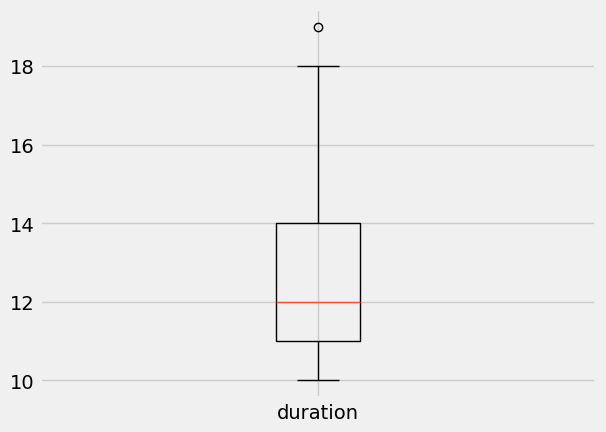

In [30]:
trip.select('duration').boxplot()

According to Google Maps, this ride is 2.0 miles and should take about 13 minutes by bike. Long rides may mean the rider went somewhere in between stat, but our longest ride is about 19 minutes. It is debatable whether or not to keep this point, but I'll keep it assuming one slow rider.

Notice that the median ride speed is 12 minutes, a minutes faster than Google predicts, but as any frequent bike rider will tell you, Google Maps tends to be conservative.

### Compare standard and ebike histograms

In [31]:
type_count = trip.group('bike_type')
type_count

bike_type,count
electric,94
standard,48


In [32]:
num_standard = type_count.column('count').item(0)
num_ebike = type_count.column('count').item(1)

In [33]:
print(f"Our total sample size is {num_standard + num_ebike} trips.")

Our total sample size is 142 trips.


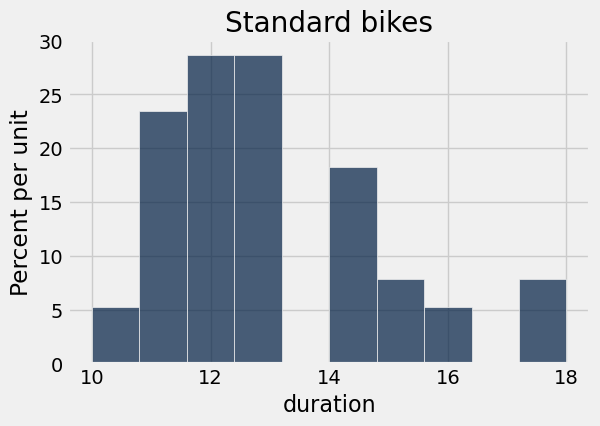

In [34]:
trip.where('bike_type', 'standard').hist('duration')
plt.title("Standard bikes");

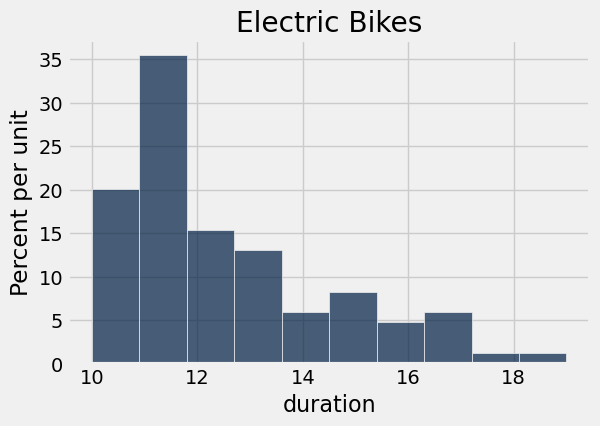

In [35]:
trip.where('bike_type', 'electric').hist('duration')
plt.title("Electric Bikes");

It certainly appears the ebike riders are a bit quicker, but is the different statistically significant?

Our test statistic will be the difference in the means.

In [36]:
standard_mean_duration = np.mean(trip.where('bike_type', 'standard').column('duration'))
ebike_mean_duration = np.mean(trip.where('bike_type', 'electric').column('duration'))
print(f"The average trip on a standard bike takes {np.round(standard_mean_duration, 2)} minutes.")
print(f"The average trip on an electric bike takes {np.round(ebike_mean_duration, 2)} minutes.")
print()
print(f"The difference in means is {np.round(standard_mean_duration - ebike_mean_duration, 2)} minutes")

The average trip on a standard bike takes 12.98 minutes.
The average trip on an electric bike takes 12.34 minutes.

The difference in means is 0.64 minutes


In [37]:
test_statistic = np.abs(standard_mean_duration - ebike_mean_duration)

So the average difference is less than a minute. Could this be random? Run a simulation!

### Simulation Under the Null Hypothesis
If the null hypothesis is true, then all of the trip durations come from the same distribution. So we repeatedly sample this distribution and calculate the difference in means.

In [38]:
def compare_means(tbl, num_standard, num_electric):
    sample1 = tbl.sample(num_standard)
    sample2 = tbl.sample(num_ebike)
    sample1_mean = np.mean(sample1.column('duration'))
    sample2_mean = np.mean(sample2.column('duration'))
    return abs(sample1_mean - sample2_mean)

In [39]:
# Test function
test = compare_means(trip, num_standard, num_ebikes)
test

0.19813829787234027

So for a single simulation the difference is small, but we need to run the simulation many time to find the distribution.

In [40]:
def simulate(num_sim):
    means = make_array()
    for i in np.arange(num_sim):
        m = compare_means(trip, num_standard, num_ebikes)
        means = np.append(means, m)
    return means

In [41]:
num_simulations = 5000
means = simulate(num_simulations)
results = Table().with_column("Means", means)

Text(0.5, 1.0, 'Simulated Differences in Means')

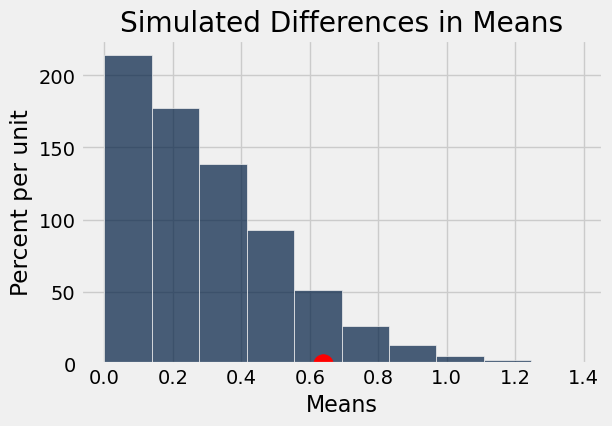

In [42]:
results.hist('Means')
plt.scatter(test_statistic, 0, color='red', s=200);
plt.title('Simulated Differences in Means')

In [43]:
p = np.count_nonzero(results.column('Means') >= test_statistic) / num_simulations
p

0.0868

## Conclusions

The distributions hinted that the riders might be slightly quicker on electric bikes, but the P-value is not <0.05, so cannot reject the null hypothesis with 95% confidence, but it is significant with 90% confidence. Thus, we conclude the riders might be significantly faster on electric bikes, at least for a two mile ride in the city.

Is is possible the difference would prove significant with 95% confidence if we had more data? Absolutely! We could easily obtain more data by analyzing more station pairs and by downloading more data from the Indego site. (An exercise for the reader ;-)

The **effect size**, however appears to be small. Does anyone care if we shave 40 seconds off of a two-mile commuter ride? Unlikely. Sometimes even results that are "statistically signficant" do not have practical importance. It does not appear the ebike riders are taking greater risks.

## Future Work
Any good scientific study ends with a reflection on possibilities for further study. There a there many ideas we could pursue:

* How does ridership change with the weather? We could download Philly weather data and compare ridership on warm, sunny days versus cold, rainy ones.
* How does ridership change with the academic calendar? Do students dominate the ridership near universities? 
* Which stations still show activity in the wee hours of the morning? Where are people riding at 3 AM?
* How has the balance between standard and ebikes changed over the last few years?
* Are there parts of the city that are under-served and could use more stations?

**Just a few of many ideas for follow-up research!**
